## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Load Dataset

In [4]:
data_dir = './GTSRB'
train_path = './GTSRB/Train'
test_path = './GTSRB/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## EDA

In [5]:
train = pd.read_csv(data_dir + '/Train.csv')
data_train = train["Path"].values

print(train.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [6]:
print("Number of Rows and Columns:", train.shape)

Number of Rows and Columns: (39209, 8)


In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB
None


In [8]:
print(train.isnull().sum())

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


In [9]:
print(train.describe())

              Width        Height        Roi.X1        Roi.Y1        Roi.X2  \
count  39209.000000  39209.000000  39209.000000  39209.000000  39209.000000   
mean      50.835880     50.328930      5.999515      5.962381     45.197302   
std       24.306933     23.115423      1.475493      1.385440     23.060157   
min       25.000000     25.000000      0.000000      5.000000     20.000000   
25%       35.000000     35.000000      5.000000      5.000000     29.000000   
50%       43.000000     43.000000      6.000000      6.000000     38.000000   
75%       58.000000     58.000000      6.000000      6.000000     53.000000   
max      243.000000    225.000000     20.000000     20.000000    223.000000   

             Roi.Y2       ClassId  
count  39209.000000  39209.000000  
mean      44.728379     15.788390  
std       21.971145     12.013238  
min       20.000000      0.000000  
25%       30.000000      5.000000  
50%       38.000000     12.000000  
75%       52.000000     25.000000  


In [9]:
print(train.duplicated().sum())

0


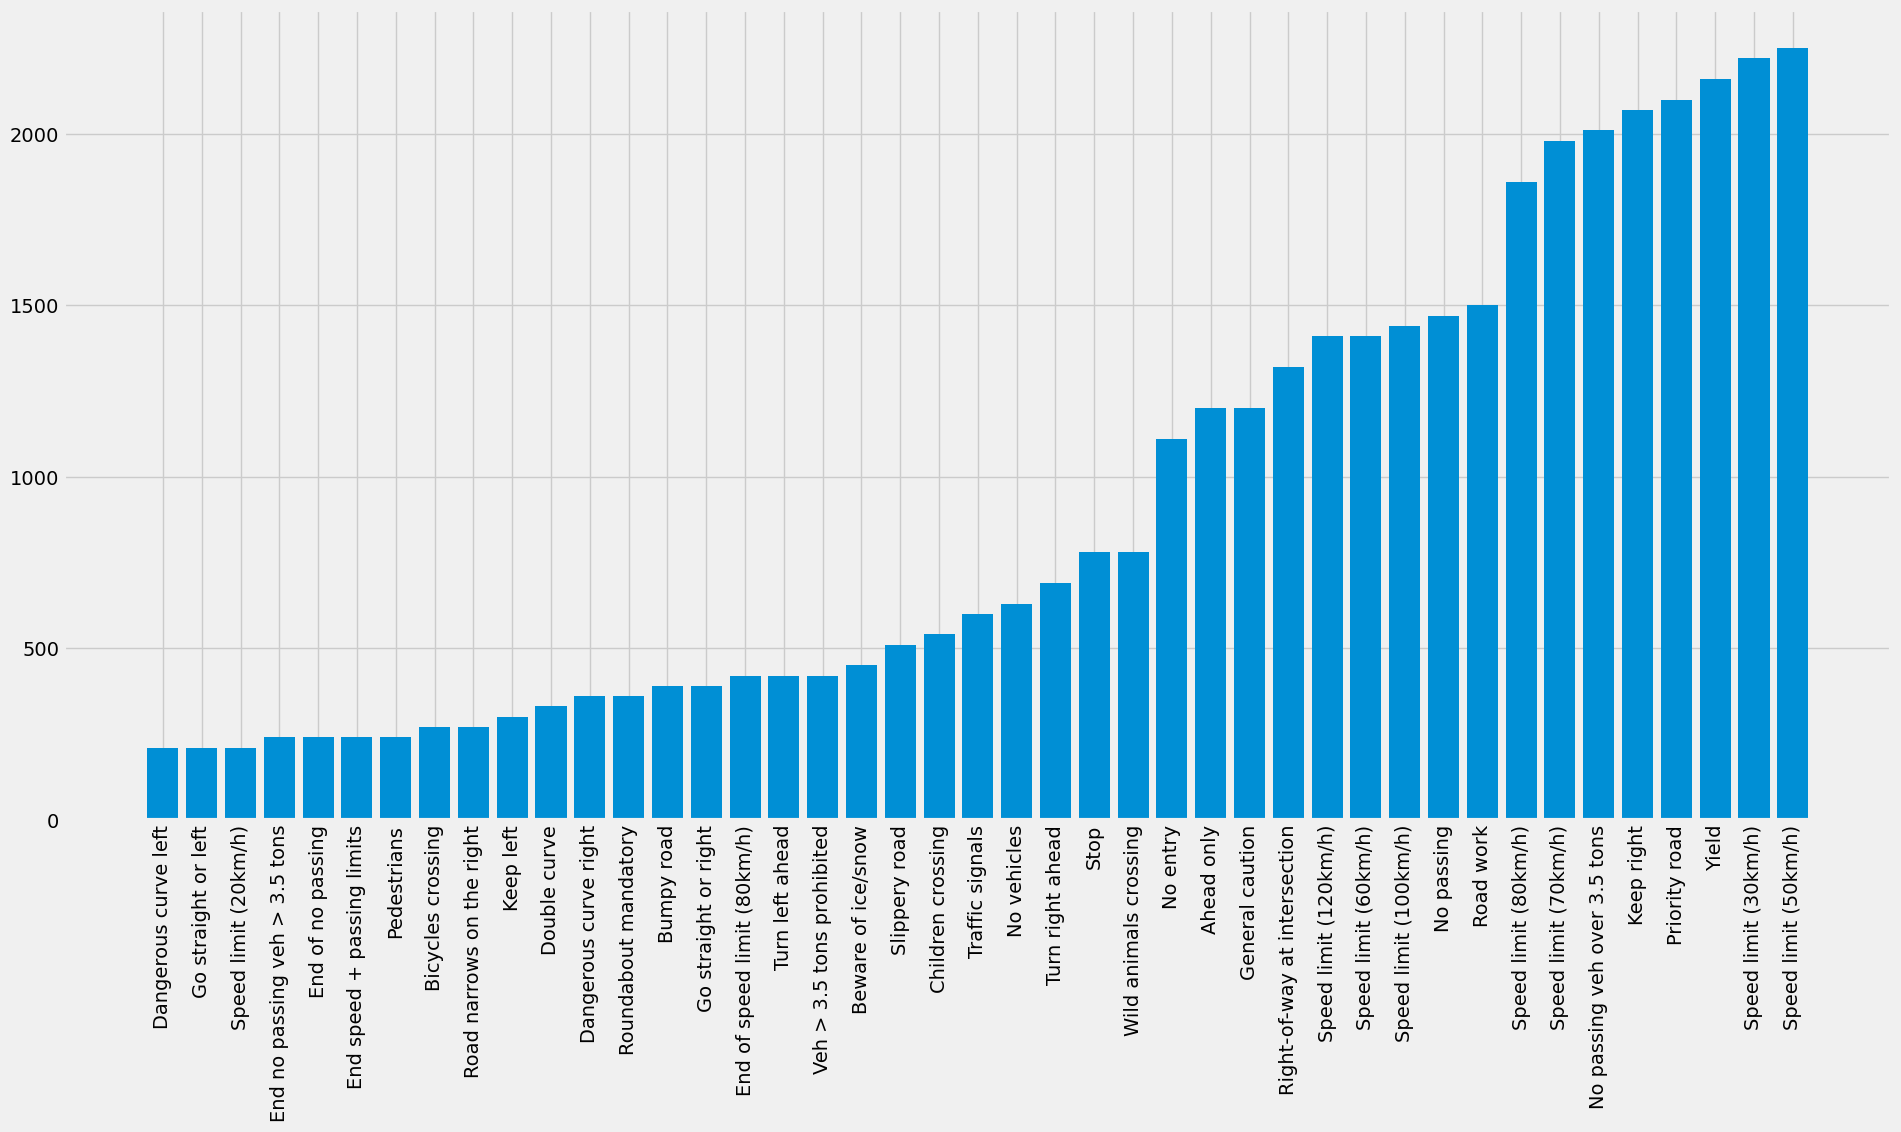

In [10]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

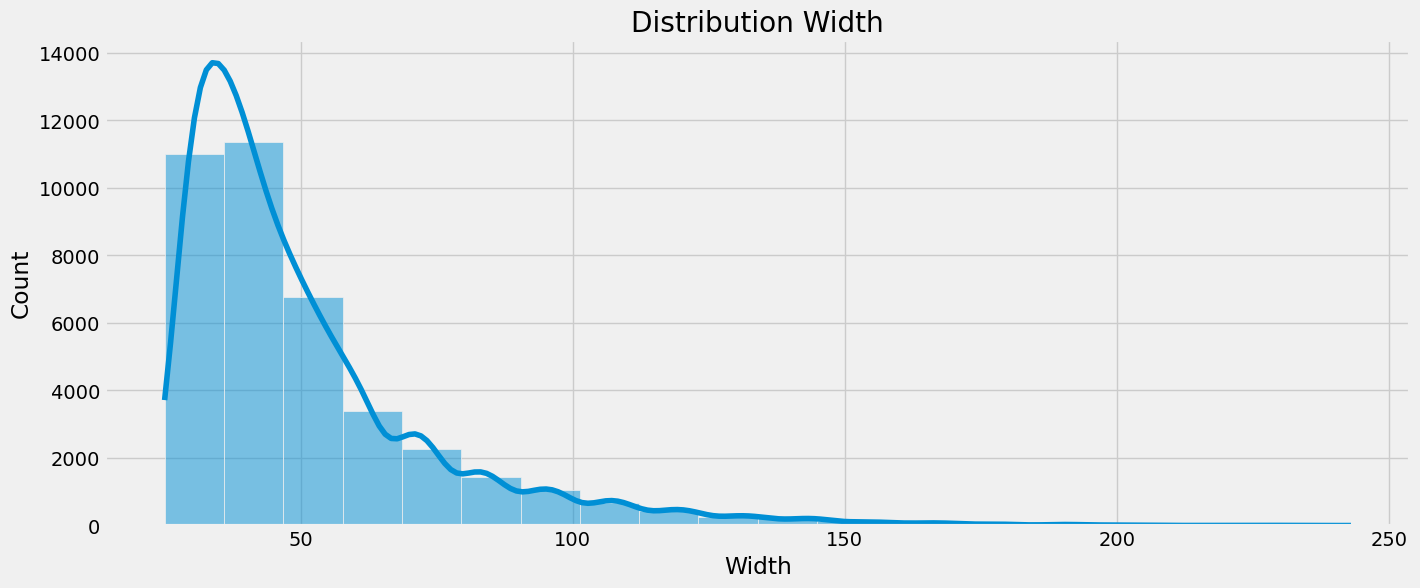

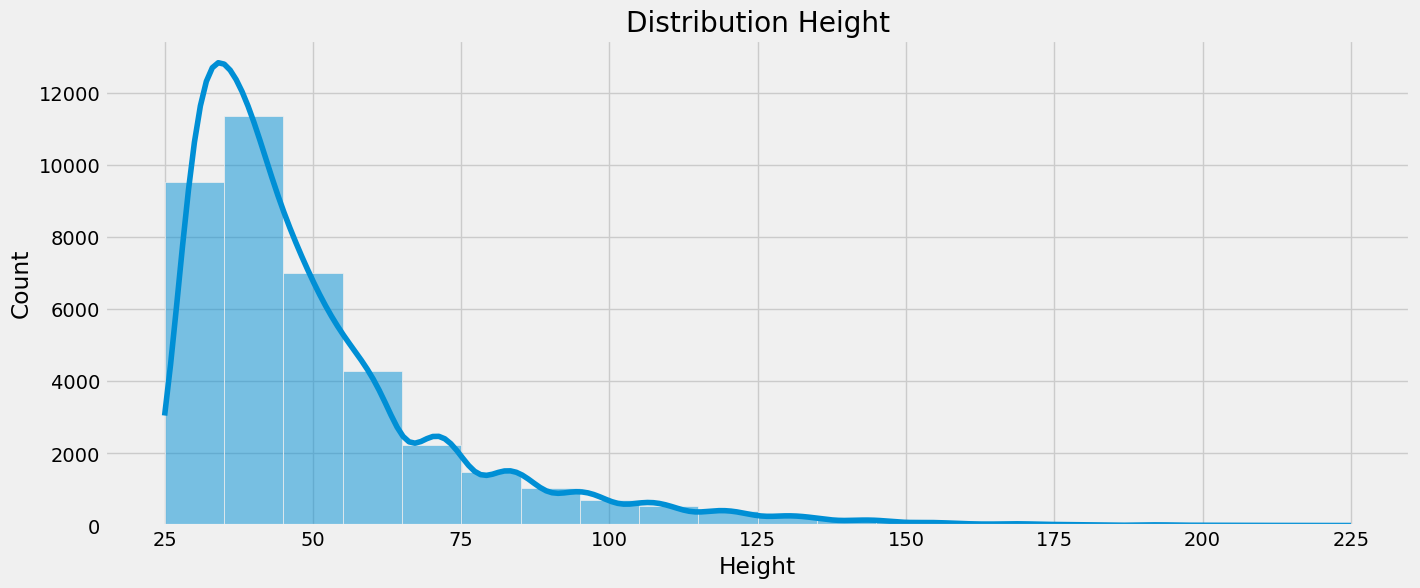

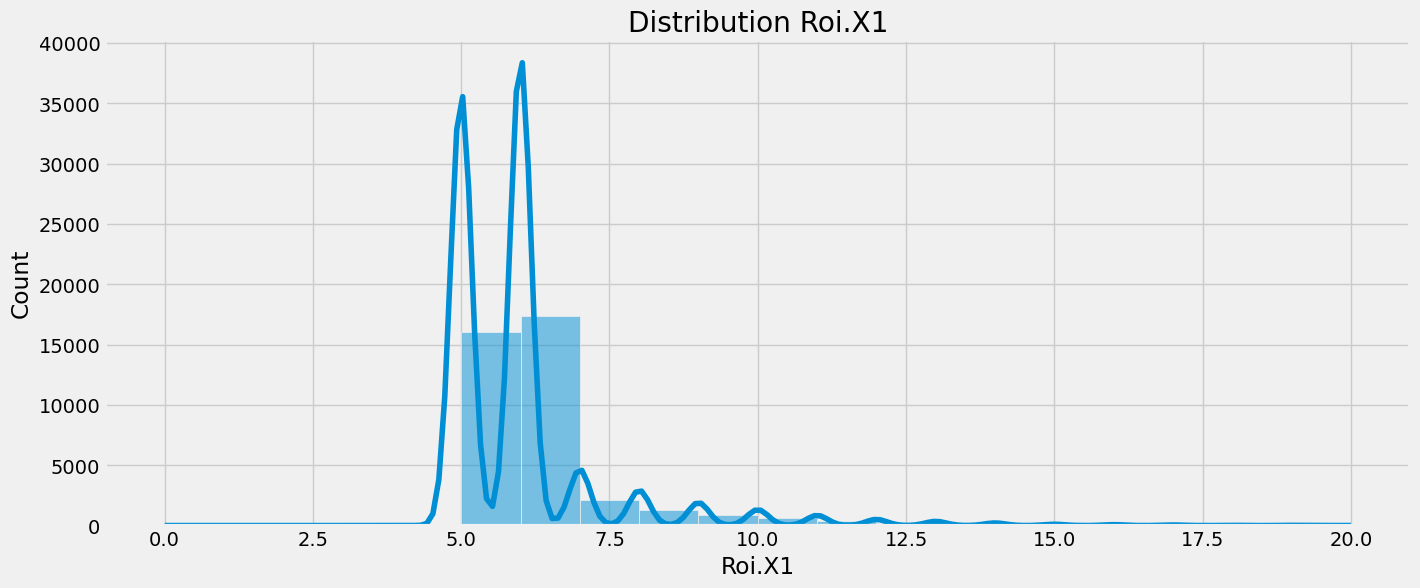

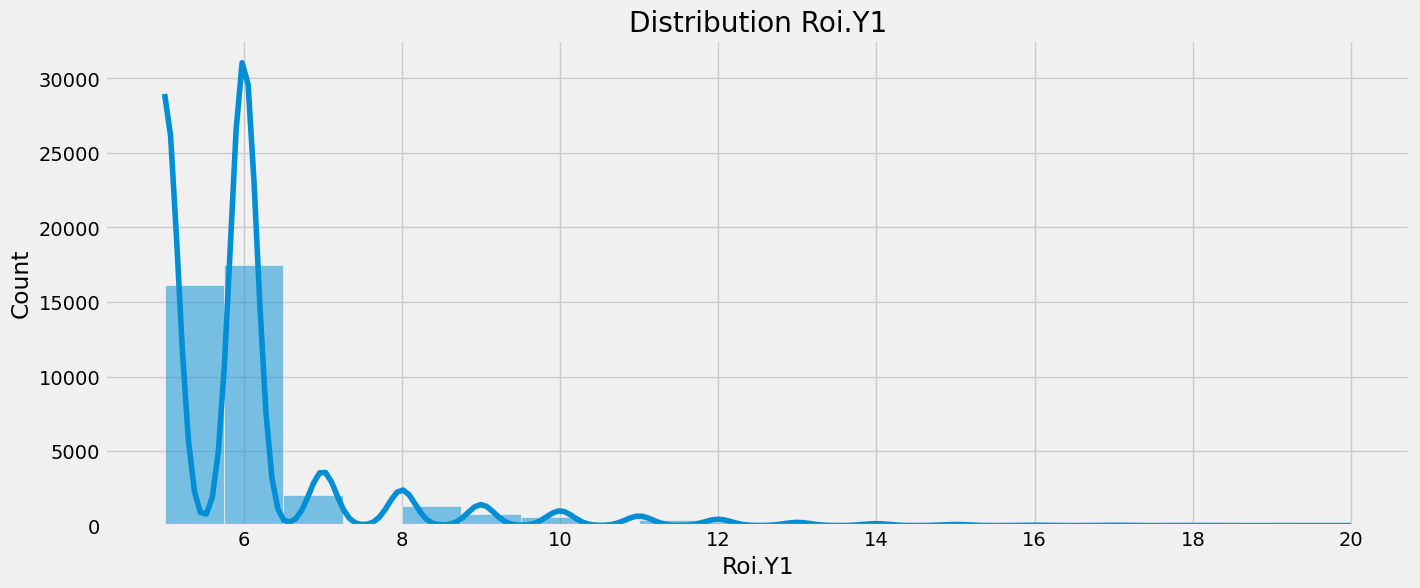

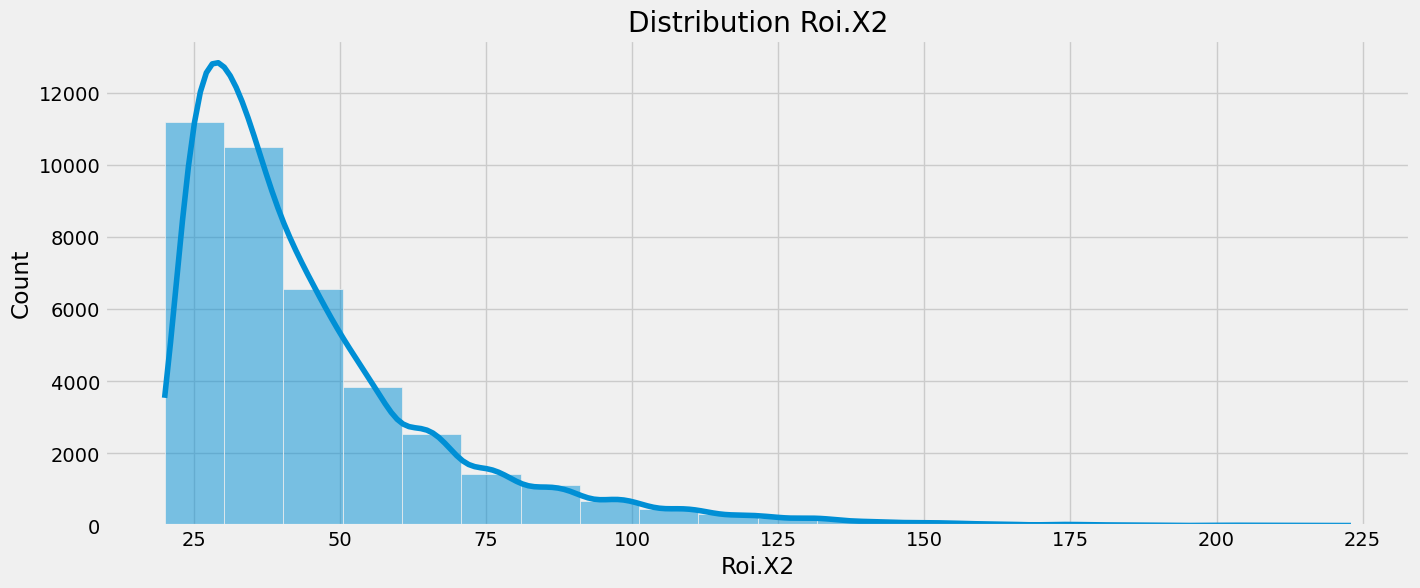

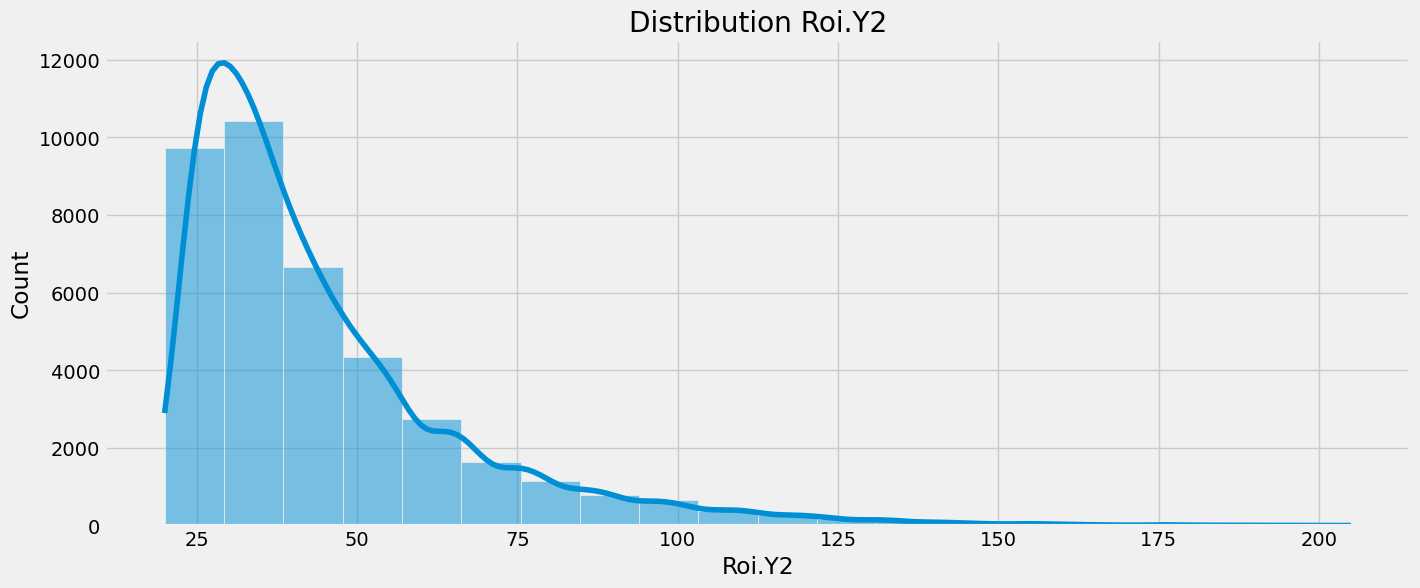

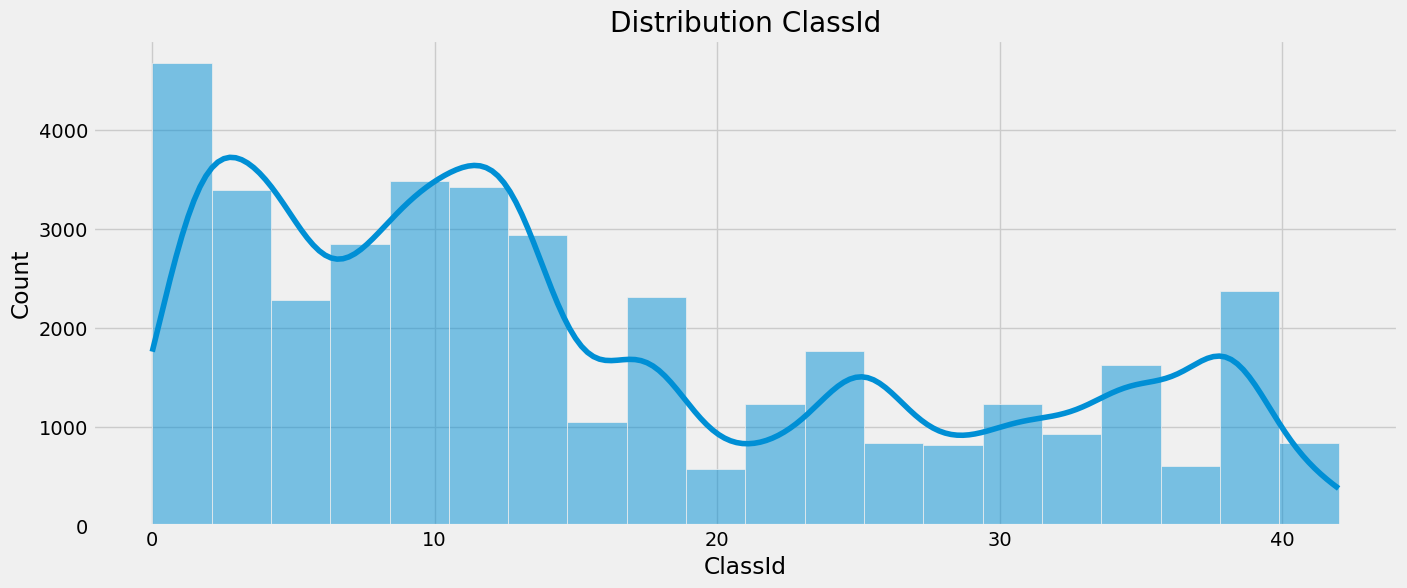

In [11]:
numerical_cols = train.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(15, 6))
    sns.histplot(train[col], bins=20, kde=True)
    plt.title(f"Distribution {col}")
    plt.show()

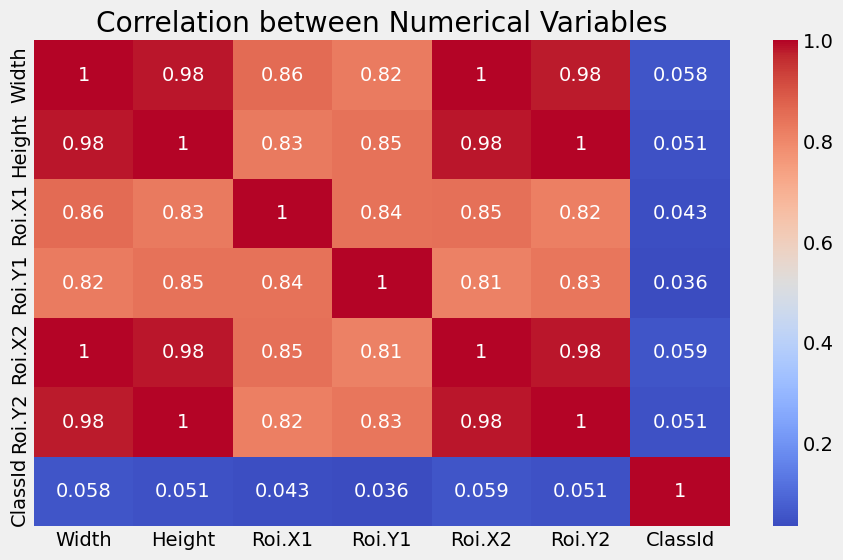

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Numerical Variables")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_17424\2997155534.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


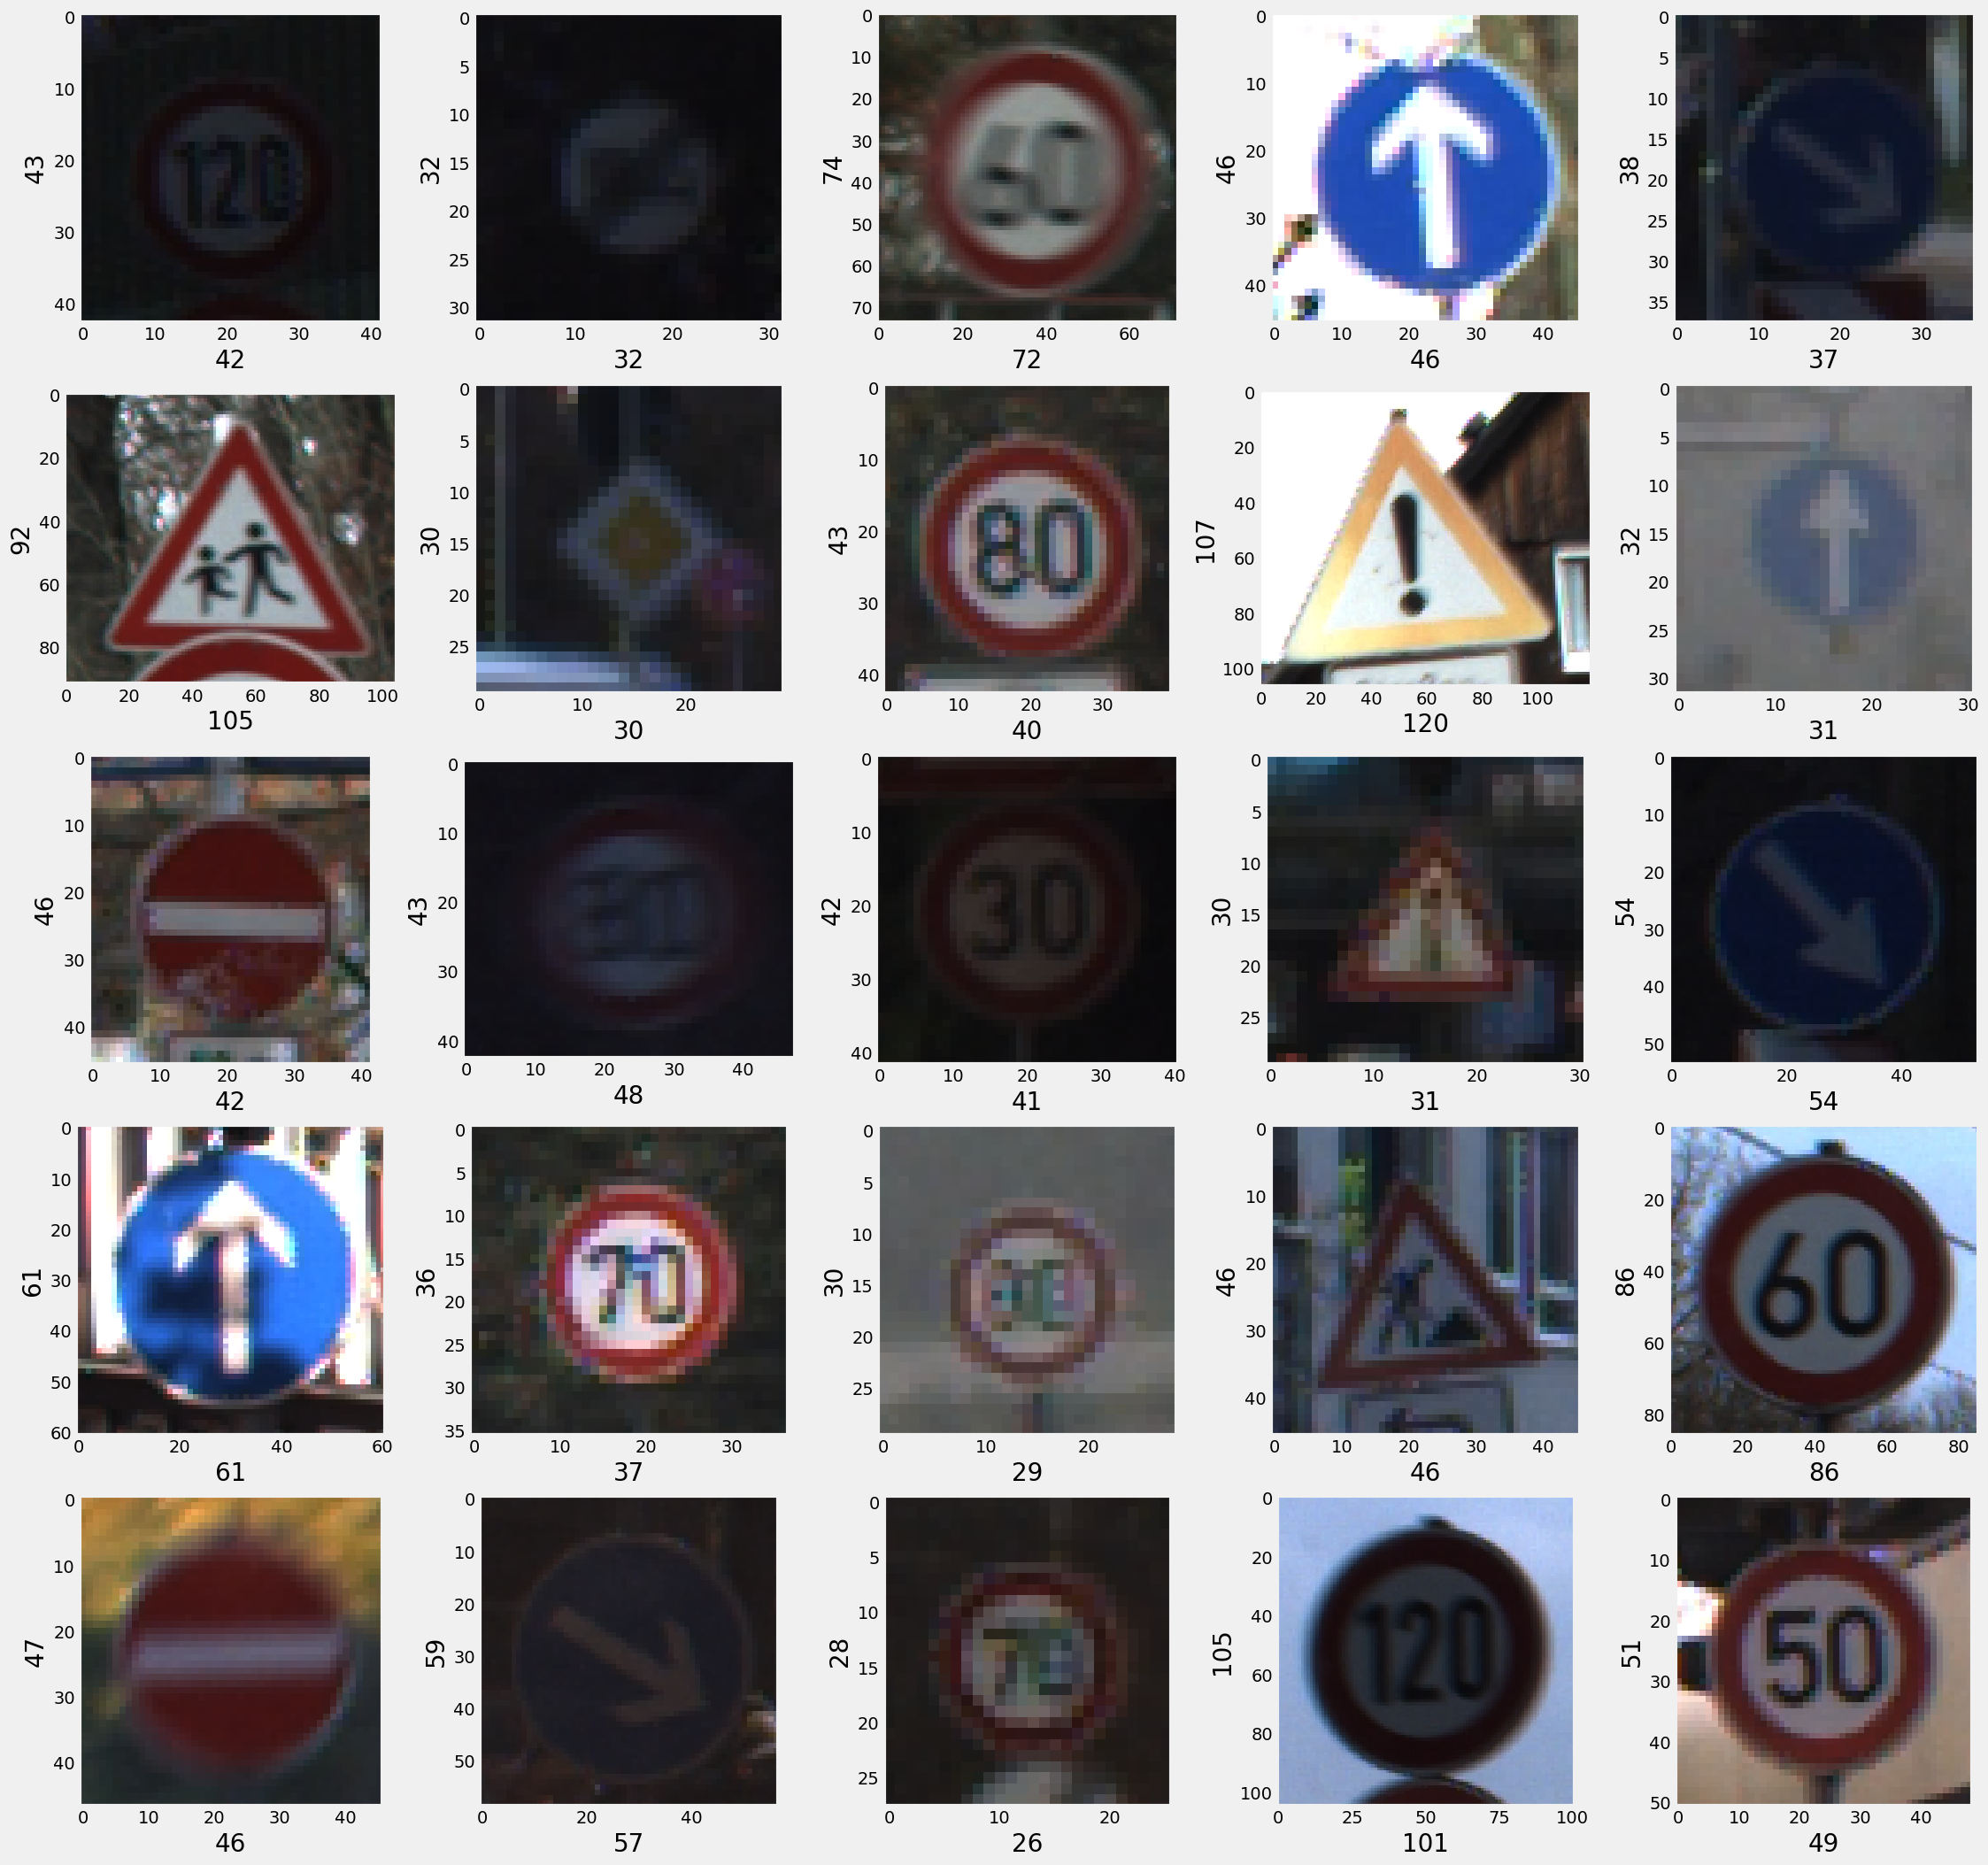

In [13]:
# Visualizing 25 random images from train data
import random
from matplotlib.image import imread

train = pd.read_csv(data_dir + '/Train.csv')
imgs = train["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [14]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [15]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [16]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [17]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [18]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

D:\Apps\Code\Anaconda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

D:\Apps\Code\Anaconda\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## Augmenting the data and training the model

In [20]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


D:\Apps\Code\Anaconda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.4960 - loss: 2.0371 - val_accuracy: 0.8868 - val_loss: 0.3318
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.9249 - loss: 0.2412 - val_accuracy: 0.9811 - val_loss: 0.0585
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9544 - loss: 0.1494 - val_accuracy: 0.9926 - val_loss: 0.0244
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.9686 - loss: 0.1007 - val_accuracy: 0.9912 - val_loss: 0.0284
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9682 - loss: 0.1016 - val_accuracy: 0.9943 - val_loss: 0.0168
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9768 - loss: 0.0803 - val_accuracy: 0.9962 - val_loss: 0.0141
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9808 - loss: 0.0626 - val_accuracy: 0.9946 - val_loss: 0.0166
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.9824 - loss: 0.0562 - val_accurac

## Evaluating the model

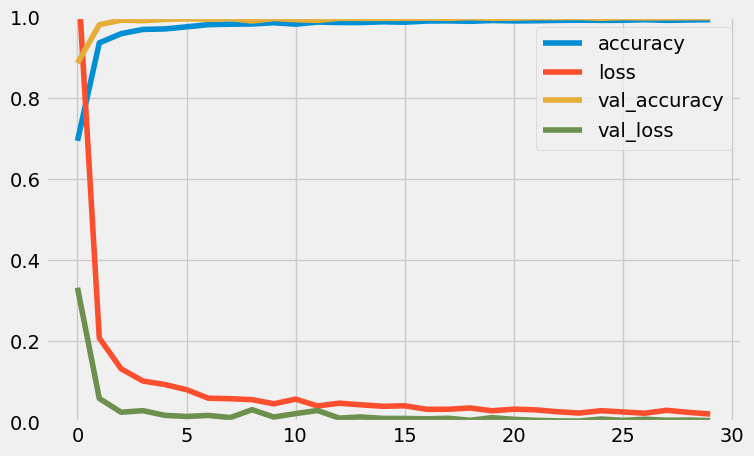

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [26]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test / 255

# Use predict method to get predicted probabilities
pred_probs = model.predict(X_test)

# Use argmax to get the predicted class
pred = np.argmax(pred_probs, axis=1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Test Data accuracy:  98.1710213776722


## Visualizing the confusion matrix

In [28]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot: >

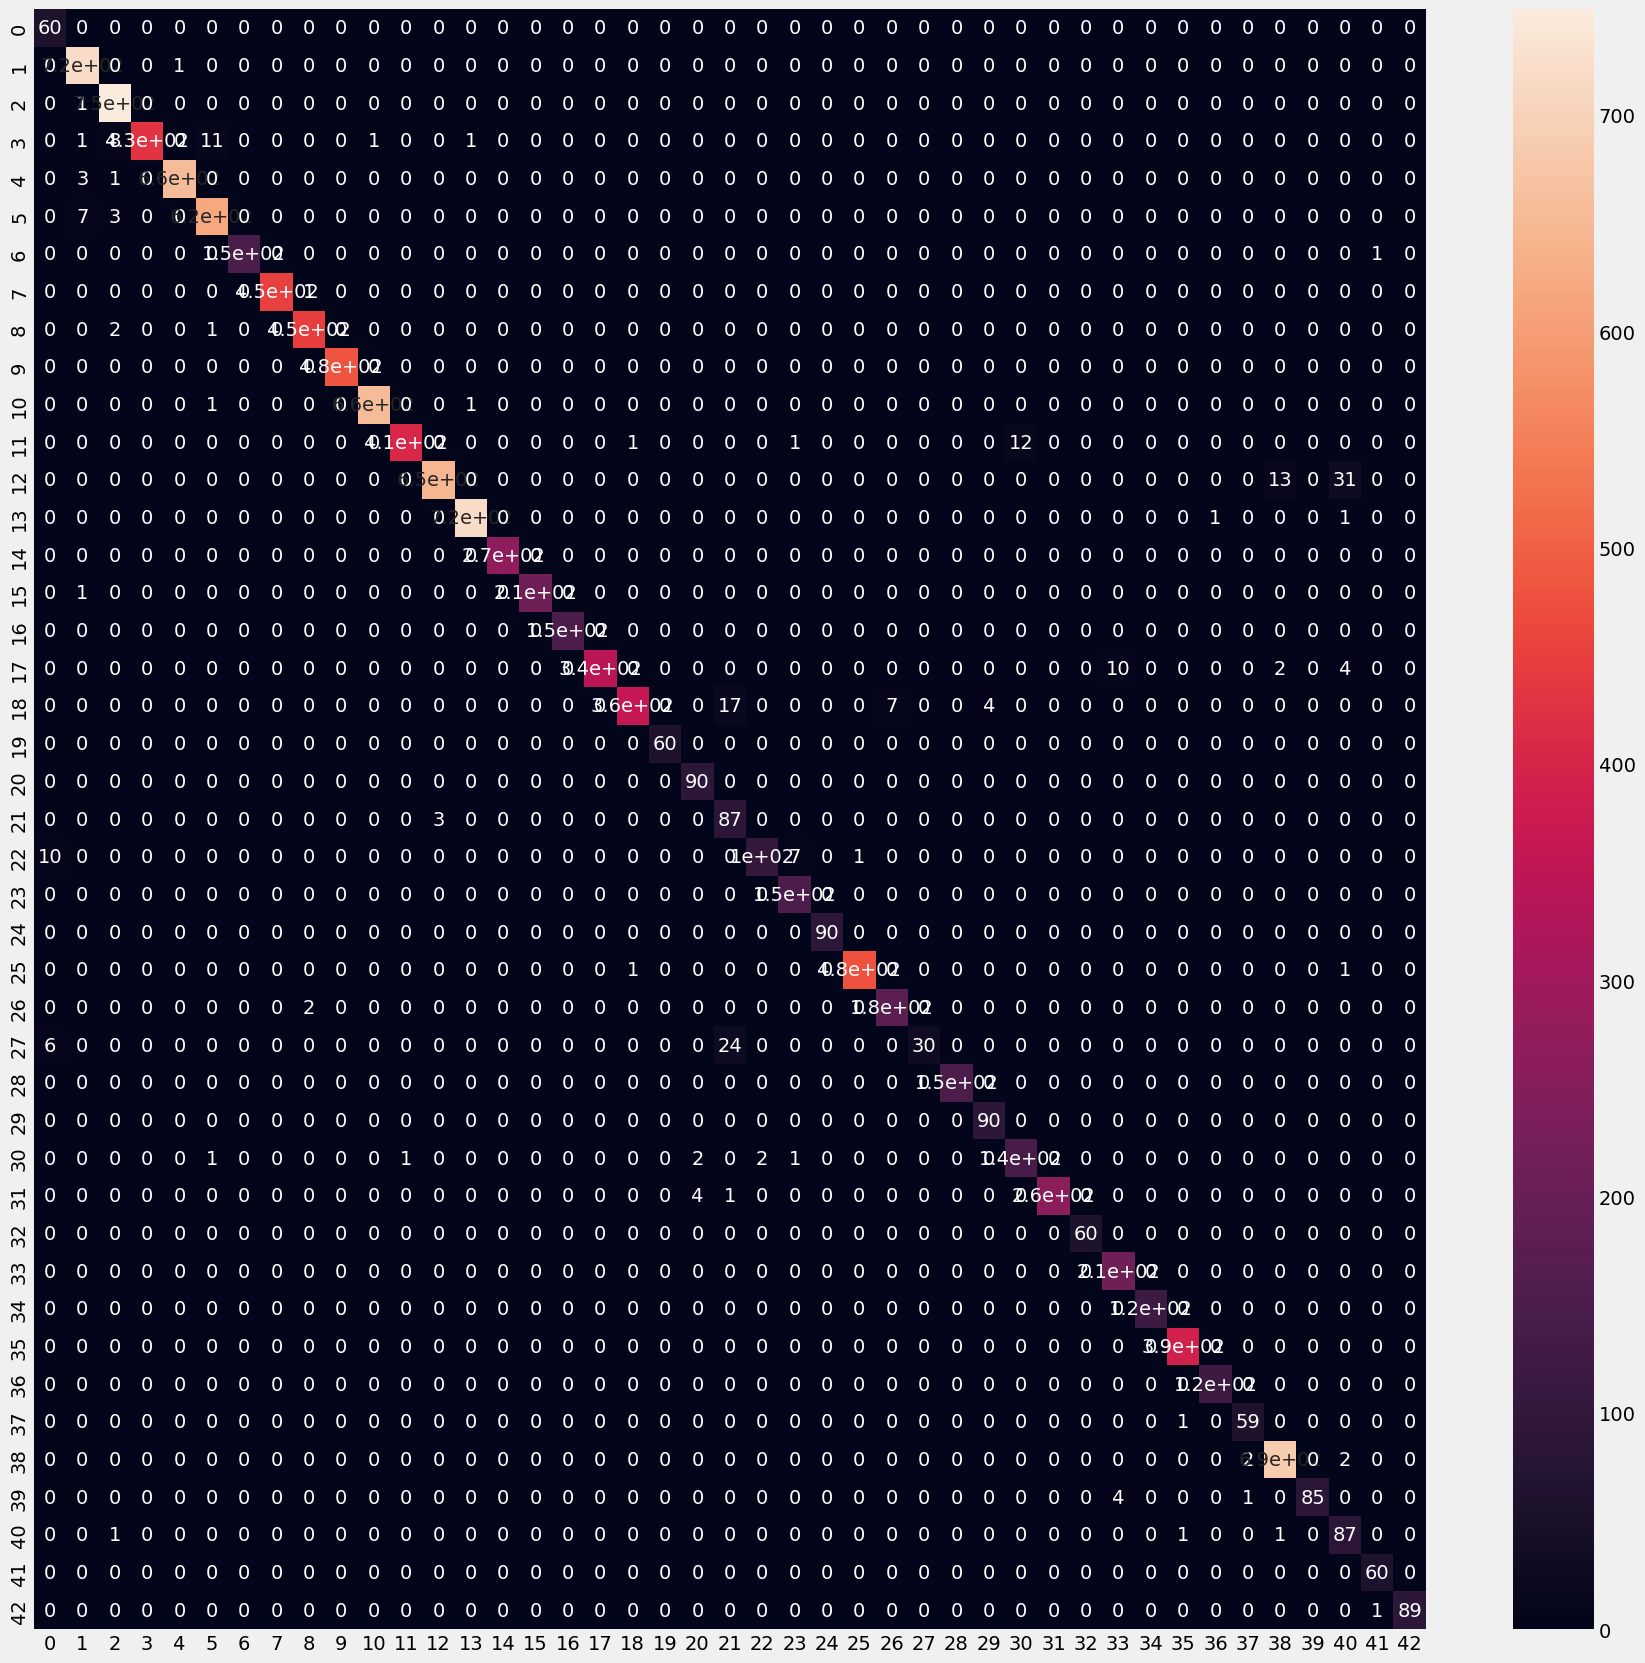

In [29]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [30]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        60
           1       0.98      1.00      0.99       720
           2       0.98      1.00      0.99       750
           3       1.00      0.95      0.97       450
           4       1.00      0.99      1.00       660
           5       0.98      0.98      0.98       630
           6       1.00      0.99      1.00       150
           7       1.00      1.00      1.00       450
           8       0.99      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.97      0.98       420
          12       1.00      0.94      0.96       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

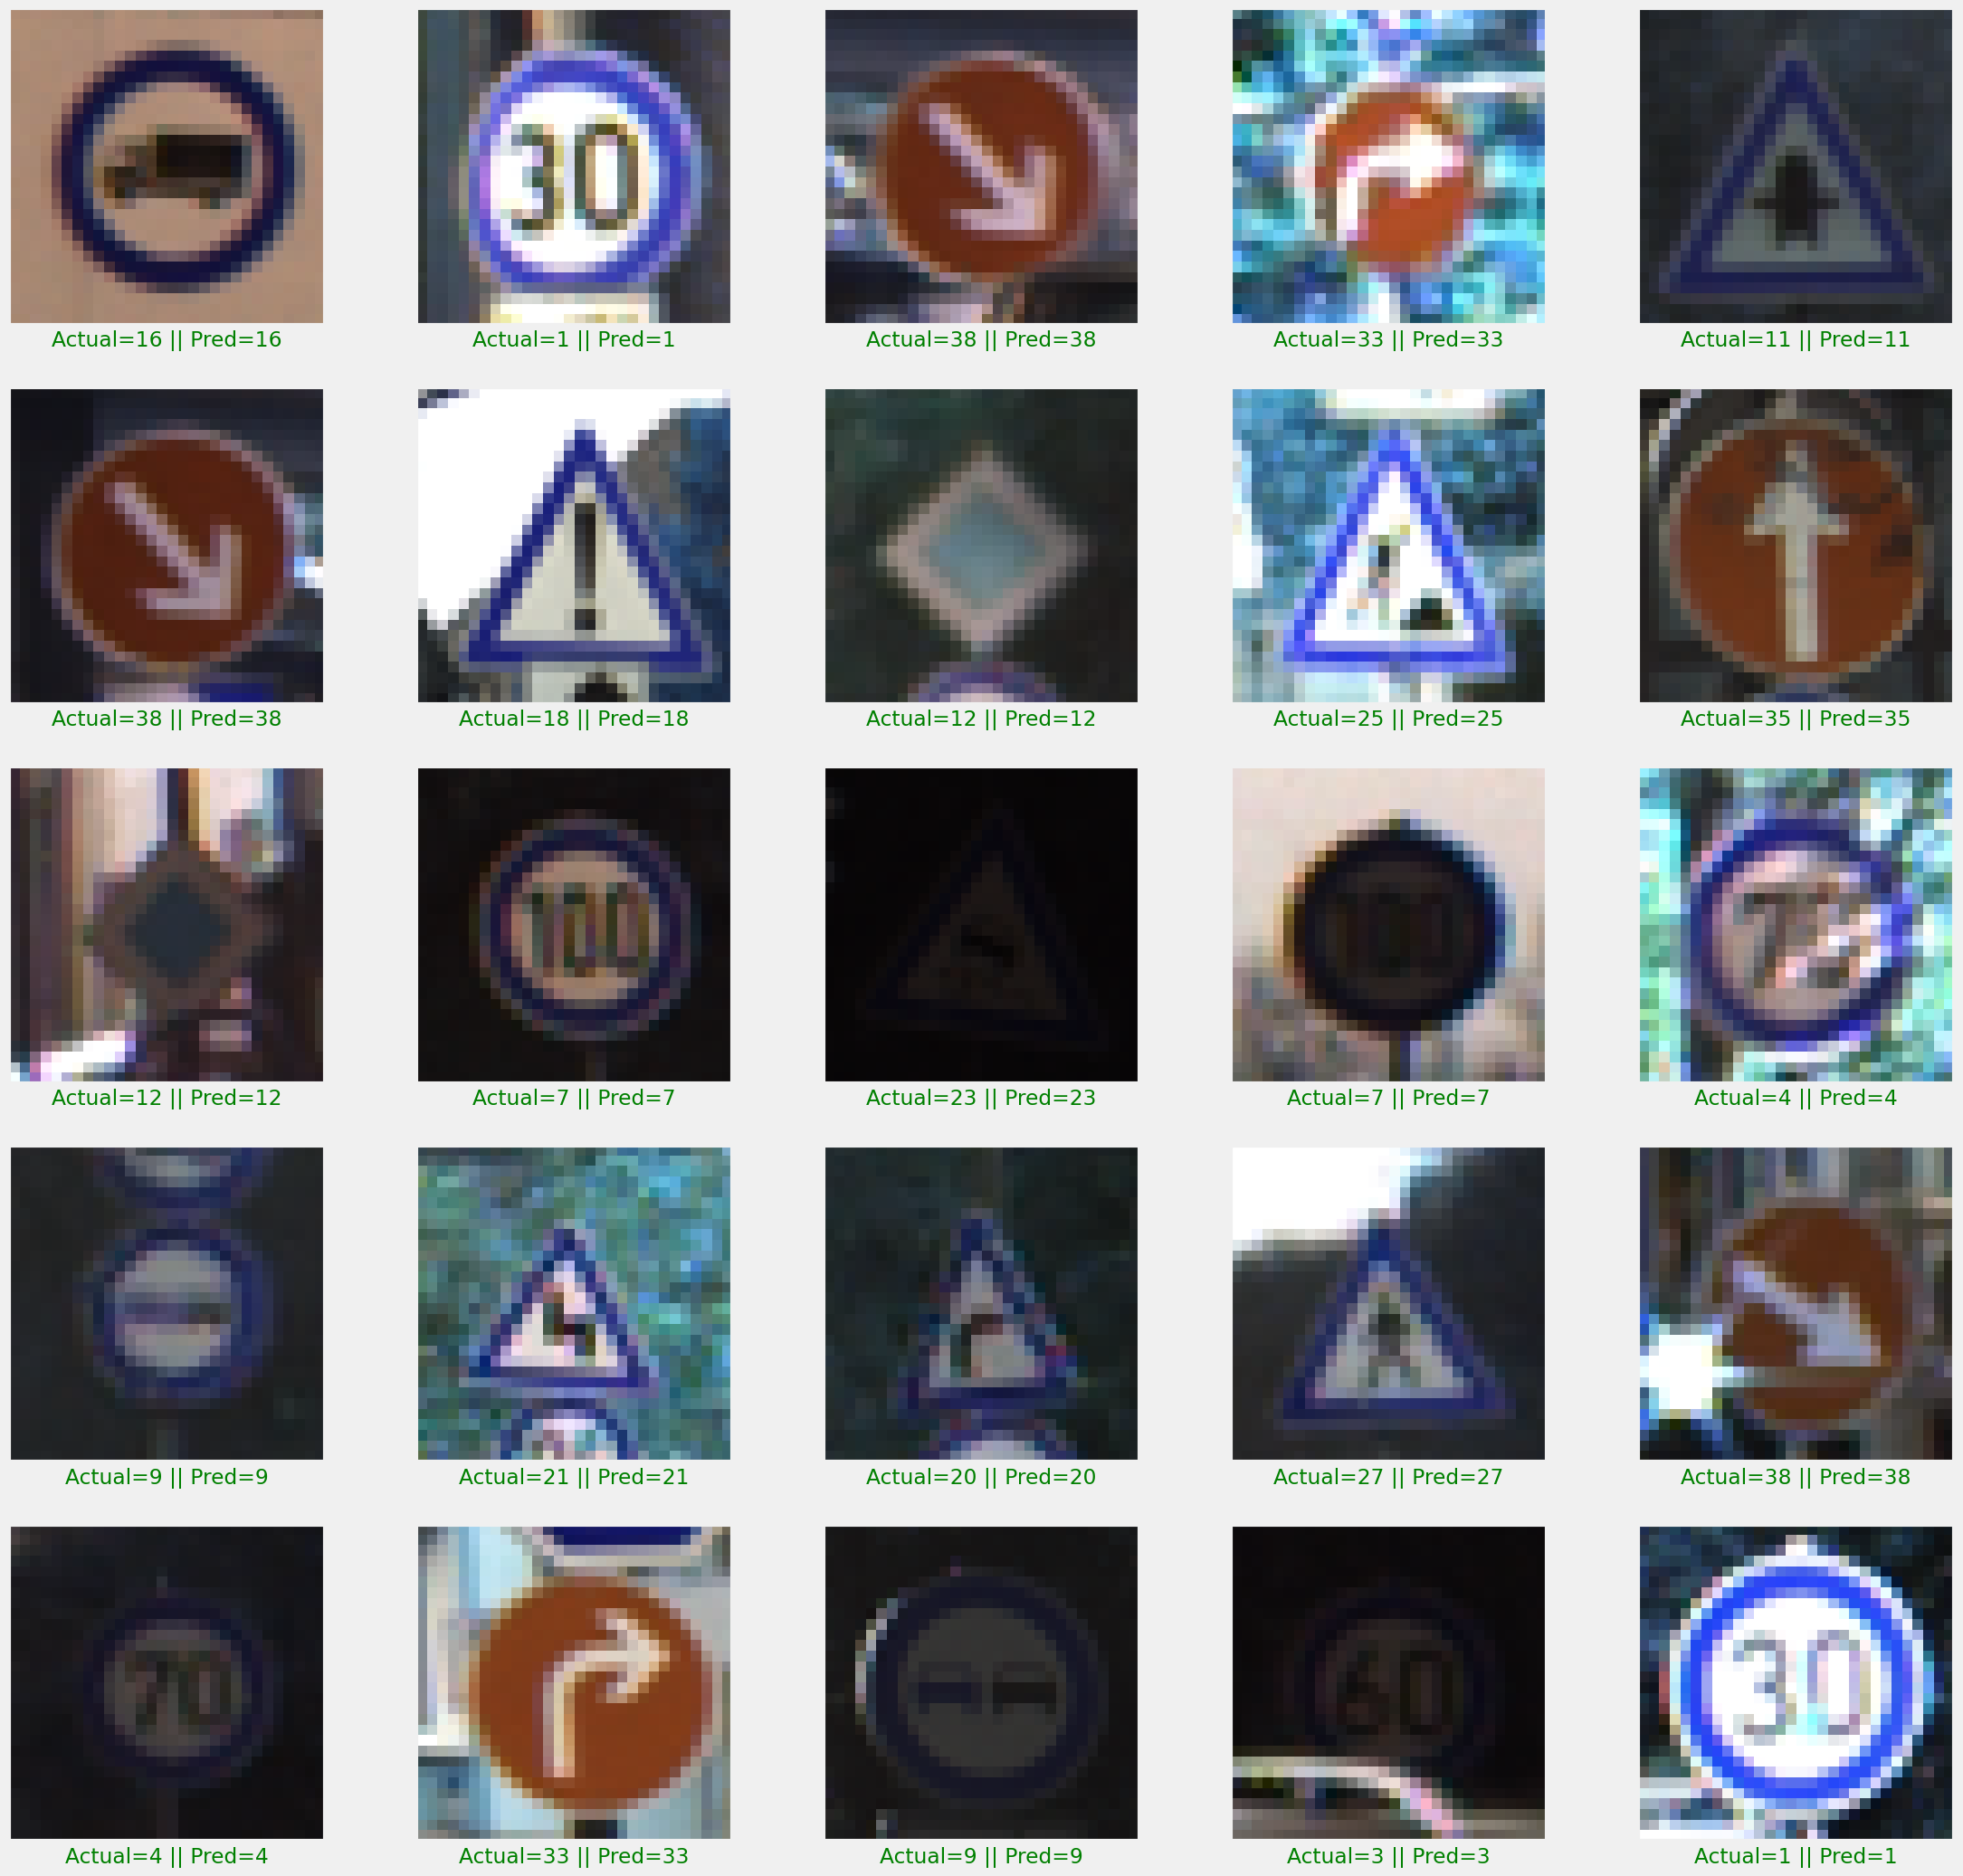

In [32]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [38]:
from keras.saving import save_model

save_model(model, 'model.keras')